In [69]:
# System packages
import os
import re
import sys
import warnings
# Data related
import numpy as np 
import pandas as pd 

# sklearn  
from sklearn.metrics import  accuracy_score
from sklearn.model_selection import train_test_split, cross_val_predict,cross_val_score,  StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
from tensorflow.keras import backend

In [65]:
# Add utils_functions.py as a dataset
from shutil import copyfile

# Copy our file into the working directory (make sure it has .py suffix)
copyfile(src = "../input/utils-functions/utils_functions.py", dst = '/kaggle/working/utils_functions.py')
from utils_functions import *

In [75]:
import types
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__
            yield val
list(imports())

['builtins',
 <module 'builtins' (built-in)>,
 'builtins',
 <module 'builtins' (built-in)>,
 'os',
 <module 'os' from '/Users/j/miniconda3/lib/python3.7/os.py'>,
 're',
 <module 're' from '/Users/j/miniconda3/lib/python3.7/re.py'>,
 'sys',
 <module 'sys' (built-in)>,
 'warnings',
 <module 'warnings' from '/Users/j/miniconda3/lib/python3.7/warnings.py'>,
 'numpy',
 <module 'numpy' from '/Users/j/miniconda3/lib/python3.7/site-packages/numpy/__init__.py'>,
 'pandas',
 <module 'pandas' from '/Users/j/miniconda3/lib/python3.7/site-packages/pandas/__init__.py'>,
 'pprint',
 <module 'pprint' from '/Users/j/miniconda3/lib/python3.7/pprint.py'>,
 'scikitplot.plotters',
 <module 'scikitplot.plotters' from '/Users/j/miniconda3/lib/python3.7/site-packages/scikitplot/plotters.py'>,
 'xgboost',
 <module 'xgboost' from '/Users/j/miniconda3/lib/python3.7/site-packages/xgboost/__init__.py'>,
 'eli5',
 <module 'eli5' from '/Users/j/miniconda3/lib/python3.7/site-packages/eli5/__init__.py'>,
 'datetime',


In [76]:
import pkg_resources
import types
def get_imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            # Split ensures you get root package, 
            # not just imported function
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):
            name = val.__module__.split(".")[0]

        # Some packages are weird and have different
        # imported names vs. system/pip names. Unfortunately,
        # there is no systematic way to get pip names from
        # a package's imported name. You'll have to had
        # exceptions to this list manually!
        poorly_named_packages = {
            "PIL": "Pillow",
            "sklearn": "scikit-learn"
        }
        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name
imports = list(set(get_imports()))

# The only way I found to get the version of the root package
# from only the name of the package is to cross-check the names 
# of installed packages vs. imported packages
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))

for r in requirements:
    print("{}=={}".format(*r))

xgboost==0.82
wordcloud==1.5.0
tensorflow==2.0.0a0
snowballstemmer==1.2.1
seaborn==0.9.0
scikit-learn==0.20.3
Pillow==5.2.0
pandas==0.24.2
numpy==1.16.3
nltk==3.4.1
matplotlib==3.0.3
gensim==3.7.3
eli5==0.8.2


## 0 Preprocessing

In [66]:
# Process df type
def df_process(df,name=None):
    df=df.dropna(subset=['Text','Gene','Variation'])
    df['Gene'] = df['Gene'].astype(str)
    df['Variation'] = df['Variation'].astype(str)
    df['Text'] = df['Text'].astype(str)
    print(df.head(1))
    #df.to_csv(name,index=False)
    #print(name,'file is saved')
    return df


In [ ]:
# Train data for training and validation
df_train = pd.read_csv('train_variants_text.csv') 
train = df_process(df_train)
train['data_type']='train'
print('train data size:',len(train))

In [ ]:
# Test data for submission
df_test = pd.read_csv('stage2_test_variants_text.csv') 
test = df_process(df_test)
test['data_type']='test'
print('test data size:',len(test))

### Combine both train and test data => all_data

In [ ]:
all_data = pd.concat([train, test], sort=False)
all_data['Text']=all_data['Text'].apply(textClean_full)
print('all_data size:',len(all_data))
all_data.to_csv('pm_all_data_clean_class_20190614.csv', index= False)   

## 1 Load preprocessed all_data 

In [14]:
all_data= pd.read_csv('/Users/j/Dropbox/Learn/health_precisionmedicine/data/processed/pm_all_data_clean_class_20190614.csv')
all_data.head(1)

,ID,Gene,Variation,Text,data_type,Class
0,0,FAM58A,Truncating Mutations,cyclin dependent kinases cdks regulate variety...,train,1.0


## 2 Featurize all_data.Text

### 2.1 Build Doc2Vec model

In [29]:
from gensim.models.doc2vec import LabeledSentence
from gensim import utils
def constructLabeledSentences(df,col):
    data = df[col]
    sentences=[]
    for index, row in data.iteritems():
        sentences.append(LabeledSentence(utils.to_unicode(row).split(), ['Text' + '_%s' % str(index)]))
    return sentences

In [30]:
sentences = constructLabeledSentences(all_data,'Text')
#sentences[0]

In [32]:
from gensim.models import Doc2Vec
def get_doc2vec_model(sentences, location,text_input_dim):
    """Returns trained word2vec    
    Args:
        sentences: iterator for sentences
        
        location (str): Path to save/load doc2vec
    """
    if os.path.exists(location):
        print('Found {}'.format(location))
        text_model = Doc2Vec.load(location)
    else:    
        print('{} not found. training model'.format(location))
        text_model = Doc2Vec(min_count=1, window=5, size=text_input_dim, sample=1e-4, negative=5, workers=4, iter=5,seed=1)
        text_model.build_vocab(sentences)
        text_model.train(sentences, total_examples=text_model.corpus_count, epochs=text_model.iter)
        text_model.save(location)
        print(location,'model is saved')
    return text_model


In [33]:
# parameters
text_input_dim =300
train_size = 3316
test_size=986

In [34]:
text_model = get_doc2vec_model(sentences, \
                               '/Users/j/Dropbox/Learn/health_precisionmedicine/src/doc2vec/doc2vec_all_20190614.d2v',\
                               text_input_dim=text_input_dim)

W0615 09:25:50.147427 140736013464448 smart_open_lib.py:385] this function is deprecated, use smart_open.open instead


Found /Users/j/Dropbox/Learn/health_precisionmedicine/src/doc2vec/doc2vec_all_20190614.d2v


In [12]:
text_model = get_doc2vec_model(sentences, '../input/pm-model-doc2vec-all/doc2vec_all_20190614.d2v',text_input_dim=text_input_dim)

Found ../input/pm-model-doc2vec-all/doc2vec_all_20190614.d2v


### 2.2 Build a feature array for  all_data.Text

In [35]:
def build_text_array(text_model, text_input_dim,train_size,test_size):
    text_train_arrays = np.zeros((train_size, text_input_dim))
    text_test_arrays = np.zeros((test_size, text_input_dim))
    for i in range(train_size):
        text_train_arrays[i] = text_model.docvecs['Text_'+str(i)]
    j=0
    for i in range(train_size,train_size+test_size):
        text_test_arrays[j] = text_model.docvecs['Text_'+str(i)]
        j=j+1
    return text_train_arrays, text_test_arrays    

### 2.3 Split the feature array for train and test

In [36]:
text_train_arrays, text_test_arrays = build_text_array(text_model, \
                                                       text_input_dim,\
                                                       train_size,\
                                                       test_size)

In [37]:
print(text_train_arrays.shape)
print(text_test_arrays.shape)

(3316, 300)
(986, 300)


In [38]:
print(text_train_arrays[0][:10])

[ 0.49902058 -0.21902579  0.23566465  0.6866526  -0.76406091 -0.47411516
 -0.10866016  0.80849326  0.36930278  0.03643488]


## 3. Featurize Gene and Variation 

In [39]:
# Dimension reduction
from sklearn.decomposition import TruncatedSVD
gene_dim=25
variation_dim=25

# Pipeline for Gene
Gene = Pipeline([
    ('selector',ItemSelector(key="Gene")),
    #('converter',Converter()),
    ('onehot',OneHotEncoder()),
    ('tsvd',TruncatedSVD(n_components=25, n_iter=gene_dim, random_state=12))
])

# Pipeline for Variation
Variation = Pipeline([
    ('selector',ItemSelector(key="Variation")),
    #('converter',Converter()),
    ('onehot',OneHotEncoder()),
    ('tsvd',TruncatedSVD(n_components=25, n_iter=variation_dim, random_state=12))
])

In [40]:
Gene_vector = Variation.fit_transform(all_data)
print(Gene_vector.shape)

Variation_vector = Variation.fit_transform(all_data)
print(Variation_vector.shape)


(4302, 25)
(4302, 25)


## 4. Stack features 

In [41]:
# Stack train and test features
def stack_train_features(Gene_vector, \
                         Variation_vector,\
                         train_size,\
                         text_train_arrays, \
                         text_test_arrays):
    train_set=np.hstack((Gene_vector[:train_size],\
                     Variation_vector[:train_size],\
                     text_train_arrays))
    test_set=np.hstack((Gene_vector[train_size:],\
                     Variation_vector[train_size:],\
                     text_test_arrays))
    return train_set, test_set

In [42]:
train_set, test_set = stack_train_features(Gene_vector, \
                         Variation_vector,\
                         train_size,\
                         text_train_arrays, \
                         text_test_arrays)

In [43]:
print(train_set.shape)
print(test_set.shape)
#print(train_set[0][:10])
input_shape=train_set.shape[1]
print(input_shape)

(3316, 350)
(986, 350)
350


## 5. Label Encoding train.Class

In [53]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder
def label_encoder(train_size):
    y = all_data.Class[:train_size]
    label_encoder = LabelEncoder()
    label_encoder.fit(y)
    encoded_y = np_utils.to_categorical((label_encoder.transform(y)))
    print(encoded_y.shape)
    return encoded_y    

In [54]:
train_y  = label_encoder(train_size)

(3316, 9)


## 6. Build Keras model 

In [55]:
# Build keras model
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding, Input, RepeatVector
from keras.optimizers import SGD

def baseline_model():
    model = Sequential()
    model.add(Dense(256,input_shape=(input_shape,)))
    #model.add(Dense(input_dim, init='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(256, init='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(80, init='normal', activation='relu'))
    model.add(Dense(9, init='normal', activation="softmax"))   
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)  
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

## 7. Training

In [61]:
# Import KerasRegressor model
from keras.wrappers.scikit_learn import KerasRegressor
clf = KerasRegressor(build_fn=baseline_model)


In [ ]:
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
# Build estimator
def build_estimator(clf,train_set, train_y, epochs,verbose):
    # split data 
    X_train, X_validation, y_train, y_validation = train_test_split(train_set, train_y, test_size=0.33, stratify=train_y, shuffle= True, random_state=42)
    # Save best model 
    weightsname = '{}{:%Y%m%dT%H%M%S}.hd5'.format(('doc2vec_keras'), datetime.datetime.now())
    checkpointer = ModelCheckpoint(filepath=weightsname, verbose=verbose, save_best_only=True)
    # Build estimator   
    estimator=clf.fit(X_train, y_train, batch_size=32, epochs=epochs, callbacks=[checkpointer],validation_data=(X_validation, y_validation))
    #estimator=clf.fit(train_set, train_y, validation_split=0.33, epochs=epochs, batch_size=32)
    return estimator

In [62]:
estimator1=build_estimator(clf,train_set, train_y, epochs=12,verbose=1)

## 8. Inspect training results

In [28]:
# Save history to a dataframe
def save_history_df(estimator):
    # Check history
    history = estimator.history
    epochs = range(1,len(next(iter(history.values())))+1)
    # Save history in a csv file
    df= pd.DataFrame(history, index=epochs)
    name = '{}{:%Y%m%dT%H%M%S}.csv'.format(('full_kaggle_keras'), datetime.datetime.now())
    print(df.head(5))
    df.to_csv(name)

In [29]:
save_history_df(estimator1)

   val_loss   val_acc      loss       acc
1  1.614802  0.400913  1.842720  0.323728
2  1.506576  0.429224  1.594035  0.415579
3  1.419462  0.482192  1.493960  0.441243
4  1.363473  0.505023  1.414563  0.470959
5  1.322060  0.549772  1.364343  0.498874


In [30]:
# Plot the history
import matplotlib.pyplot as plt
def plot_history(estimator):
    fig = plt.figure(figsize=(5,5))
    #plt.subplot(121)
    plt.plot(estimator.history['acc'])
    plt.plot(estimator.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()

# summarize history for loss
    #plt.subplot(122)
    fig = plt.figure(figsize=(5,5))
    plt.plot(estimator.history['loss'])
    plt.plot(estimator.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    figname = '{}{:%Y%m%dT%H%M%S}.png'.format(('fullkeras'), datetime.datetime.now())
    fig.savefig(figname,figdpi = 600)
    plt.close()
    

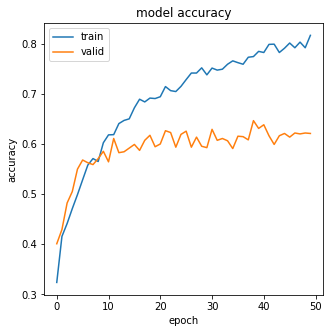

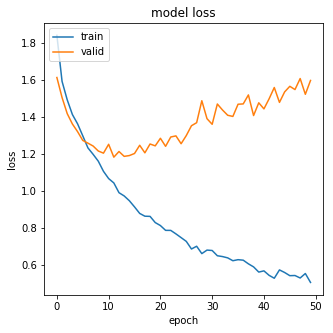

In [31]:
plot_history(estimator1)

In [ ]:
## Run into overfitting